Introducción: ¿Por qué analizar patrones estacionarios en series temporales para predecir el déficit de energía?
Antes de construir un modelo predictivo (como ARIMA, SARIMA o Prophet), es crucial verificar si la serie temporal asociada al déficit de energía cumple con la estacionariedad. Esto se debe a que:

Los modelos clásicos de series temporales asumen estacionariedad.

Si la serie tiene tendencias o estacionalidad, los modelos pueden generar predicciones sesgadas o poco confiables.

Ejemplo: Si la demanda_maxima aumenta con el tiempo (tendencia creciente), un modelo ARIMA sin ajustes fallará.

Identificar patrones ayuda a elegir el preprocesamiento correcto.

Diferenciación para eliminar tendencias.

Transformaciones (log, Box-Cox) para estabilizar la varianza.

Descomposición para separar estacionalidad.

Evitar sobreajuste o subajuste.

Una serie no estacionaria puede llevar a modelos que capturen ruido en lugar de señales reales.

Análisis de Estacionariedad en tus Datos
Vamos a evaluar la estacionariedad para una variable clave, como deficit_predicho o demanda_maxima, usando métodos estadísticos y visuales.

1. Visualización de la Serie Temporal
Graficamos la serie para inspeccionar:

Tendencia: ¿Aumenta/disminuye con el tiempo?

Estacionalidad: ¿Patrones cíclicos (diarios, semanales, mensuales)?

Ruido: ¿Variabilidad aleatoria?

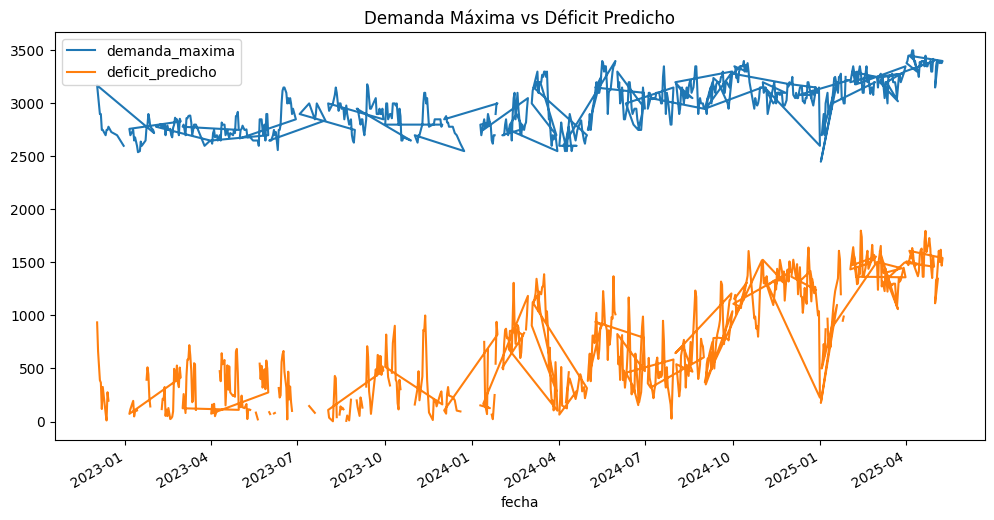

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = '../data/processed/cleaned_energy_data.csv'
# Cargar datos (ejemplo)
df = pd.read_csv(file_path, parse_dates=['fecha'], index_col='fecha')

# Graficar demanda máxima y déficit predicho
df[['demanda_maxima', 'deficit_predicho']].plot(figsize=(12, 6))
plt.title('Demanda Máxima vs Déficit Predicho')
plt.show()

2. Prueba de Dickey-Fuller Aumentada (ADF)
Test estadístico para estacionariedad:

Hipótesis nula (p > 0.05): La serie no es estacionaria.

Hipótesis alternativa (p ≤ 0.05): La serie es estacionaria.

In [3]:
from statsmodels.tsa.stattools import adfuller

# Prueba ADF para 'demanda_maxima'
result = adfuller(df['demanda_maxima'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-valor: {result[1]}')
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.57101620978446
p-valor: 0.006339933146099431
Valores críticos:
   1%: -3.4399324443722814
   5%: -2.865768564020576
   10%: -2.5690218258831052



Primeras filas del DataFrame:
                fecha   año  mes  dia  dia_semana  es_fin_semana  \
0 2022-12-30 08:29:00  2022   12   30           4              0   
1 2022-12-23 10:33:00  2022   12   23           4              0   
2 2022-12-17 08:56:00  2022   12   17           5              1   
3 2022-12-14 08:42:00  2022   12   14           2              0   
4 2022-12-13 08:46:00  2022   12   13           1              0   

   demanda_maxima  disponibilidad_total  afectacion_predicha  \
0          2600.0                3109.0                  NaN   
1          2700.0                2713.0                 60.0   
2          2730.0                2815.0                  NaN   
3          2780.0                2583.0                267.0   
4          2750.0                2474.0                346.0   

   deficit_predicho  respaldo  disponibilidad_07am  demanda_07am  \
0               NaN       NaN               2660.0        1750.0   
1               NaN      13.0          

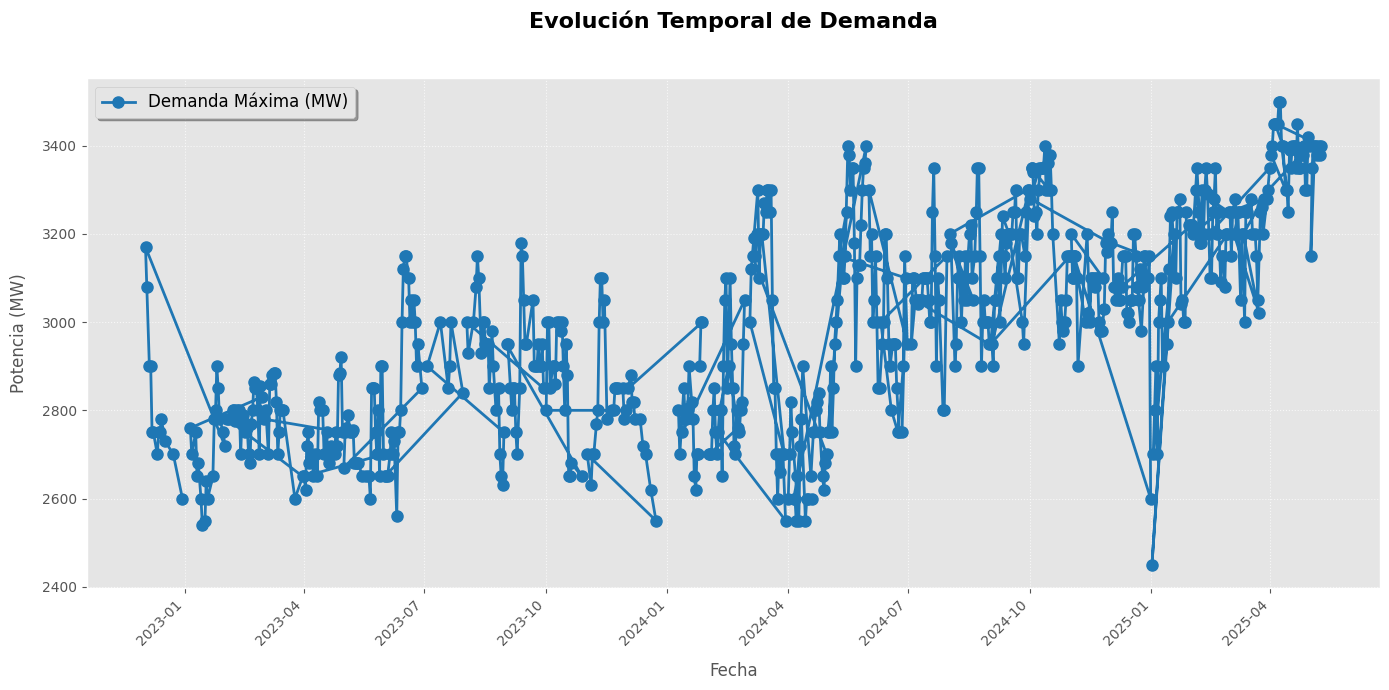

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Leer el archivo CSV
# Reemplaza 'datos_energia.csv' con la ruta correcta a tu archivo
try:
    df = pd.read_csv('../data/processed/cleaned_energy_data.csv', parse_dates=['fecha'])
except FileNotFoundError:
    print("Error: No se encontró el archivo. Verifica la ruta y el nombre del archivo.")
    exit()

# 2. Verificar que tenemos los datos correctamente cargados
print("\nPrimeras filas del DataFrame:")
print(df.head())
print("\nResumen de los datos:")
print(df.info())

# 3. Configuración del gráfico
plt.figure(figsize=(14, 7))
plt.style.use('ggplot')  # Estilo moderno (opcional)

# 4. Crear el gráfico de líneas principal
# Demanda máxima
plt.plot(df['fecha'], df['demanda_maxima'], 
         marker='o', markersize=8, linestyle='-', linewidth=2, color='#1f77b4',
         label='Demanda Máxima (MW)')



# 5. Personalización avanzada del gráfico
plt.title('Evolución Temporal de Demanda\n', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12, labelpad=10)
plt.ylabel('Potencia (MW)', fontsize=12, labelpad=10)

# Configurar ejes
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, framealpha=1, shadow=True)

# Formatear fechas en el eje x
plt.gcf().autofmt_xdate(rotation=45)
plt.tight_layout()

# 6. Mostrar y guardar el gráfico
plt.savefig('grafico_energia.png', dpi=300, bbox_inches='tight', transparent=False)
print("\nGráfico guardado como 'grafico_energia.png'")
plt.show()

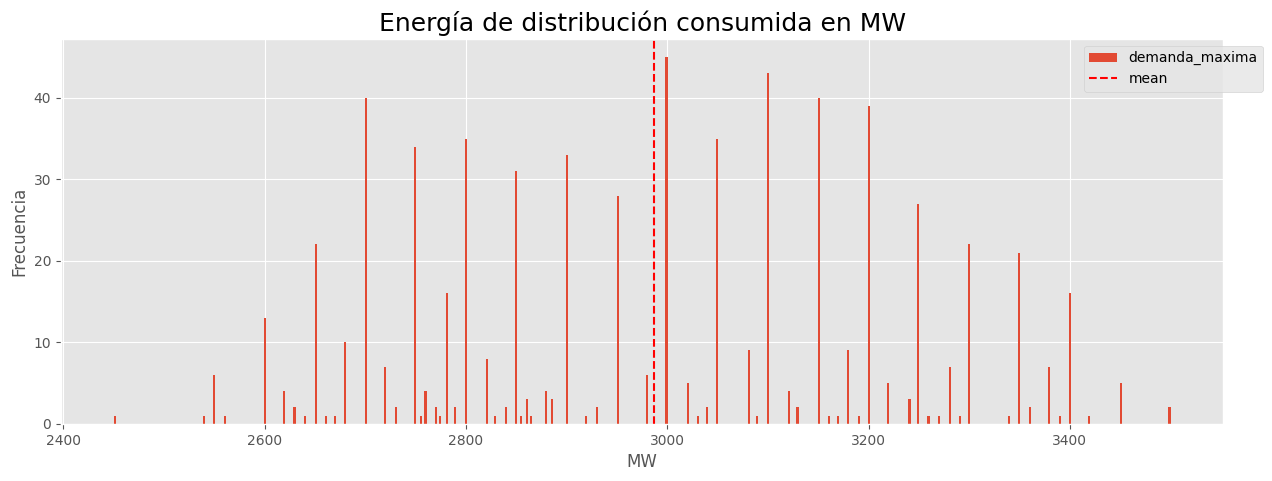

In [5]:
mean_MW = df['demanda_maxima'].mean()
mean_MW

df['demanda_maxima'].plot(figsize = (15,5), kind = 'hist', bins = 500)

plt.title('Energía de distribución consumida en MW', fontsize=18)

plt.xlabel('MW', fontsize=12)

plt.ylabel('Frecuencia', fontsize=12)

plt.axvline(x=mean_MW, color='r', linestyle = '--', label = 'mean')

plt.legend(bbox_to_anchor=(1.04,1));

El grafico muestra que la mayoria de los datos se encuentran en el rango de demanda maxima de entre 2600 y los 3400. Tomaremos los datos inferiores a 2600 como atipicos con esta query

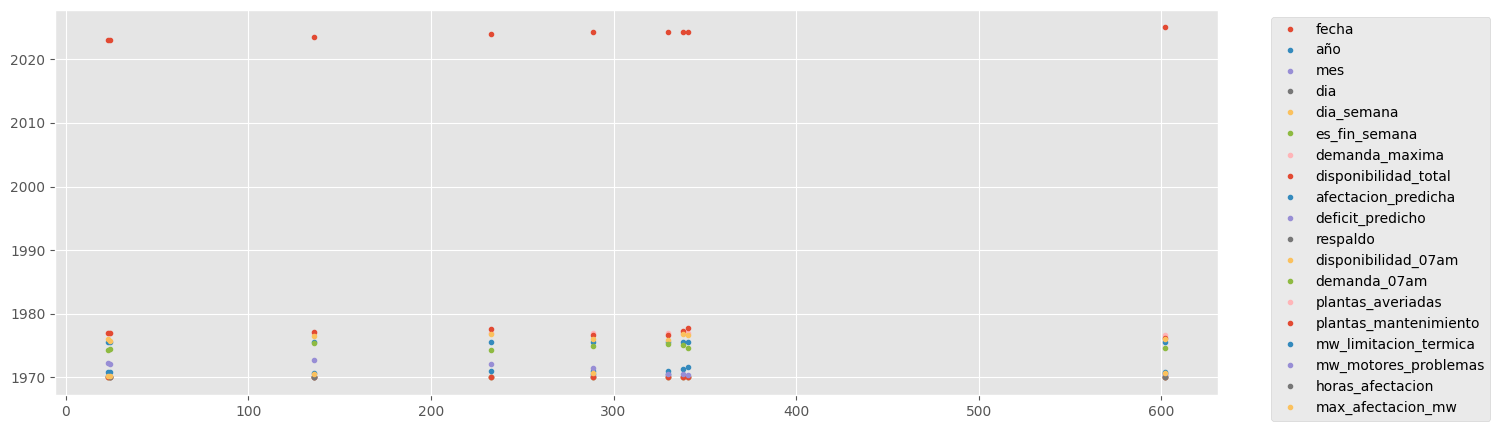

In [6]:
df.query('demanda_maxima < 2600').plot(figsize = (15,5), style = '.')
plt.legend(bbox_to_anchor=(1.04,1));

In [7]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Asegurar que el DataFrame esté ordenado por fecha
df = df.sort_index()

# Configurar TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=2,test_size=168,gap=24)

for train_index, val_index in tss.split(df):
    print(f"Train: {len(train_index)}, Val: {len(val_index)}")


Train: 336, Val: 168
Train: 504, Val: 168


'n_splits': Especifica el número de divisiones o pliegues que se van a crear, establecido en 2 en este caso por tener una muestra de 696 dias, que es un conjunto bastante pequenno.

- 'test_size': Define el tamaño del conjunto de pruebas para cada división, lo que representa 1 año de datos y 24 horas al día.

- 'gap': Establece el intervalo entre los conjuntos de entrenamiento y prueba, representado por 24 horas.

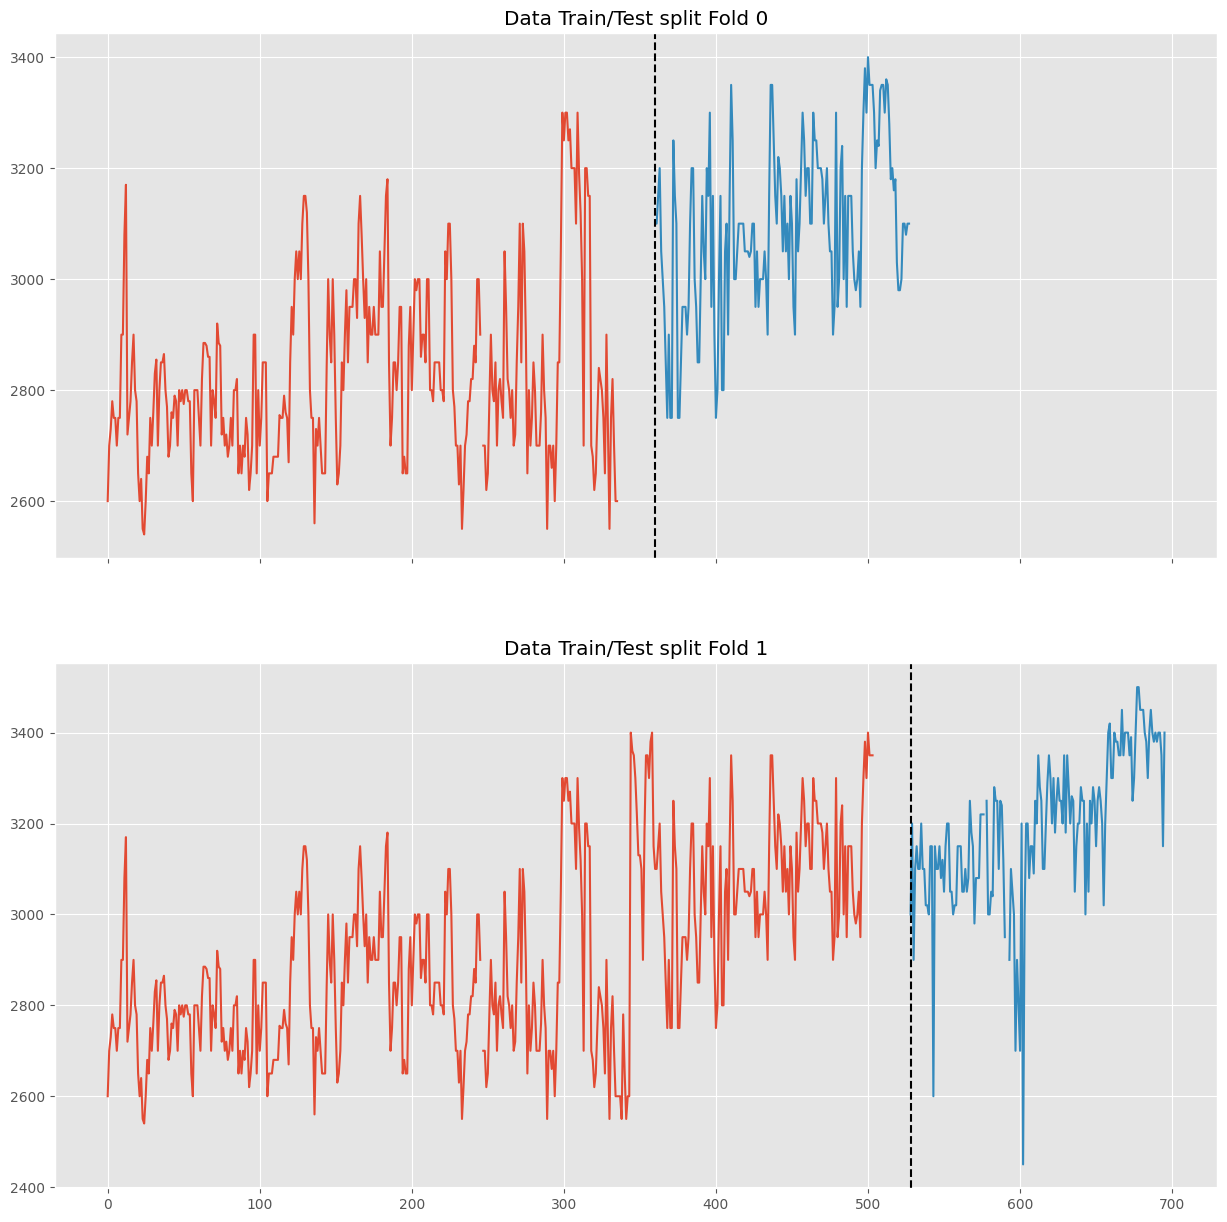

In [8]:
fig, axs = plt.subplots(2, 1,figsize = (15,15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train =df.iloc[train_index]
    test = df.iloc[val_index]
    train['demanda_maxima'].plot(ax = axs[fold],
                         label = 'Training Set',
                         title = f'Data Train/Test split Fold {fold}')
    test['demanda_maxima'].plot(ax = axs[fold], label = 'Test Set')
    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold += 1

In [9]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df.copy()
    df['dia_semana'] = df.index.dayofweek
    df['mes'] = df.index.month
    df['año'] = df.index.year
    df['dia'] = df.index.day
    df['lag1'] = df['demanda_maxima'].shift(1)
    df['lag2'] = df['demanda_maxima'].shift(2)
    return df

C:\Users\Amalia\AppData\Local\Temp\ipykernel_7264\922536993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='mes', y='demanda_maxima', palette='Blues')


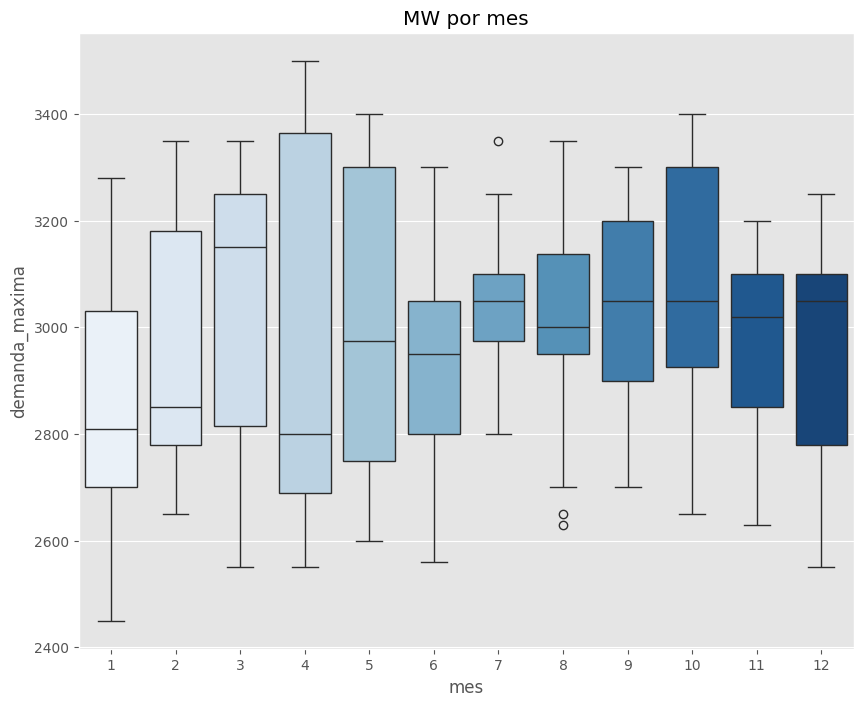

In [10]:
import seaborn as sns 
fig, ax= plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='mes', y='demanda_maxima', palette='Blues')
ax.set_title('MW por mes');

In [11]:
def add_lags(df):
    # Asegurarnos de que la columna 'fecha' es el índice y es datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index('fecha')
        df.index = pd.to_datetime(df.index)
    
    # Crear el diccionario de mapeo usando el índice datetime como clave
    target_map = df['demanda_maxima'].to_dict()
    
    # Calcular los lags
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('696 days')).map(target_map)
    
    return df

# Ejecutar la función
print(add_lags(df))

                      año  mes  dia  dia_semana  es_fin_semana  \
fecha                                                            
2022-12-30 08:29:00  2022   12   30           4              0   
2022-12-23 10:33:00  2022   12   23           4              0   
2022-12-17 08:56:00  2022   12   17           5              1   
2022-12-14 08:42:00  2022   12   14           2              0   
2022-12-13 08:46:00  2022   12   13           1              0   
...                   ...  ...  ...         ...            ...   
2025-05-05 09:10:00  2025    5    5           0              0   
2025-05-03 08:39:00  2025    5    3           5              1   
2025-05-02 11:58:00  2025    5    2           4              0   
2025-05-01 11:50:00  2025    5    1           3              0   
2025-05-04 11:00:00  2025    5    4           6              1   

                     demanda_maxima  disponibilidad_total  \
fecha                                                       
2022-12-30 08:29:00


DataFrame con características creadas:
                      año  mes  dia  dia_semana  es_fin_semana  \
fecha                                                            
2023-01-13 09:02:00  2023    1   13           4              0   
2023-02-21 10:32:00  2023    2   21           1              0   
2023-02-20 08:09:00  2023    2   20           0              0   
2023-03-05 09:08:00  2023    3    5           6              1   
2023-04-02 09:31:00  2023    4    2           6              1   

                     demanda_maxima  disponibilidad_total  \
fecha                                                       
2023-01-13 09:02:00          2600.0                2496.0   
2023-02-21 10:32:00          2800.0                2303.0   
2023-02-20 08:09:00          2770.0                2674.0   
2023-03-05 09:08:00          2700.0                2620.0   
2023-04-02 09:31:00          2620.0                2460.0   

                     afectacion_predicha  deficit_predicho  respaldo 

<Figure size 1200x600 with 0 Axes>

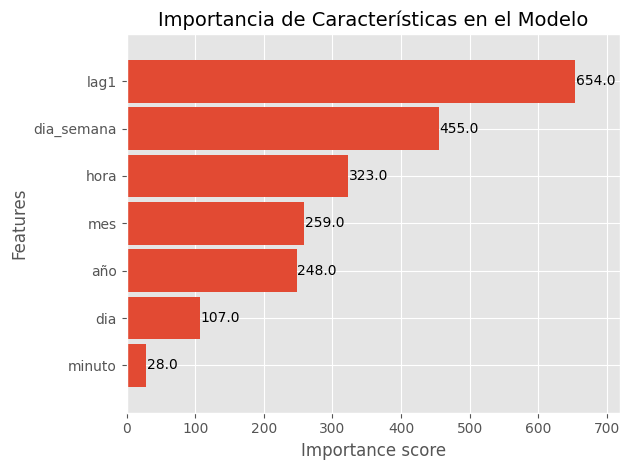

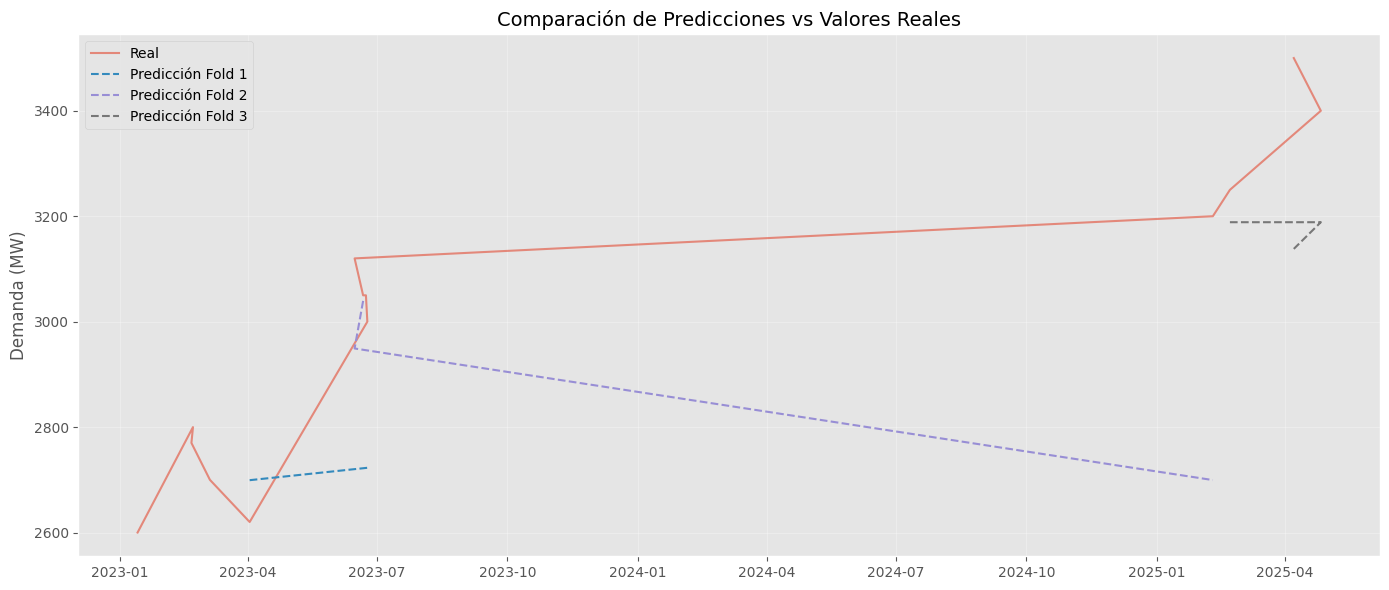

In [ ]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar los datos
df = pd.read_csv('../data/processed/cleaned_energy_data.csv', parse_dates=['fecha'])
df.set_index('fecha', inplace=True)  # Establecer índice temporal

# 2. Función para crear características temporales y estadísticas
def create_features(df):
    df = df.copy()
    df['dia_semana'] = df.index.dayofweek
    df['mes'] = df.index.month
    df['año'] = df.index.year
    df['dia'] = df.index.day
    df['hora'] = df.index.hour
    df['minuto'] = df.index.minute

    # Variables rezagadas
    df['lag1'] = df['demanda_maxima'].shift(1)
    df['lag24'] = df['demanda_maxima'].shift(24)

    # Ventanas móviles
    df['rolling_mean_24'] = df['demanda_maxima'].rolling(window=24).mean()
    df['rolling_max_24'] = df['demanda_maxima'].rolling(window=24).max()

    return df.dropna()  # Eliminar filas con NaN por lags y rolling

# 3. Crear características
df = create_features(df)
print("\nDataFrame con características creadas:")
print(df.head())

# 4. Configurar TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=3)  # O usa test_size/gap si tu versión lo permite
val_indices_list = []  # Guardar los índices para graficar luego

# 5. Entrenamiento del modelo
FEATURES = ['dia_semana', 'mes', 'año', 'dia', 'hora', 'minuto',
            'lag1', 'lag24', 'rolling_mean_24', 'rolling_max_24']
TARGET = 'demanda_maxima'

fold = 0
preds = []
scores = []

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    val_indices_list.append(val_index)

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01,
        random_state=42
    )

    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    fold += 1
    print(f'\nFold {fold} RMSE: {score:.2f} MW')
    print('-' * 50)

print(f'\nRMSE promedio: {np.mean(scores):.2f} ± {np.std(scores):.2f} MW')

# 6. Importancia de características
plt.figure(figsize=(12, 6))
xgb.plot_importance(reg, height=0.9, importance_type='weight', max_num_features=15)
plt.title('Importancia de Características en el Modelo', fontsize=14)
plt.tight_layout()
plt.show()

# 7. Visualización de predicciones vs reales
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['demanda_maxima'], label='Real', alpha=0.6)
for i, pred in enumerate(preds):
    val_dates = df.iloc[val_indices_list[i]].index
    plt.plot(val_dates, pred, label=f'Predicción Fold {i+1}', linestyle='--')

plt.title('Comparación de Predicciones vs Valores Reales', fontsize=14)
plt.ylabel('Demanda (MW)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def create_features(df):
    df = df.copy()
    df['Hour'] = df.index.hour
    df['Day_of_Week'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Day_of_Year'] = df.index.dayofyear

    # Lags
    df['lag1'] = df['PJME_MW'].shift(1)
    df['lag2'] = df['PJME_MW'].shift(2)
    df['lag3'] = df['PJME_MW'].shift(3)

    return df.dropna()

tss = TimeSeriesSplit(n_splits=2)  # usa esto si no tienes sklearn >= 1.1
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year', 'Day_of_Year', 'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',
        max_depth=3,
        learning_rate=0.01
    )

    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


KeyError: "['Hour', 'Day_of_Week', 'Quarter', 'Month', 'Year', 'Day_of_Year', 'lag2', 'lag3'] not in index"

In [12]:
def create_features(df):
    """
    Crea características específicas para tu conjunto de datos de energía.
    """
    df = df.copy()
    
    # Convertir fecha a datetime si no lo está
    if not isinstance(df.index, pd.DatetimeIndex):
        df['fecha'] = pd.to_datetime(df['fecha'])
        df = df.set_index('fecha')
    
    # Características temporales (ya tienes muchas en tus datos)
    # Podemos complementar con:
    df['hora'] = df.index.hour
    df['es_hora_pico'] = ((df['hora'] >= 18) & (df['hora'] <= 22)).astype(int)
    
    # Variables operacionales clave
    df['total_plantas_inactivas'] = df['plantas_averiadas'] + df['plantas_mantenimiento']
    df['problemas_generacion'] = df['mw_limitacion_termica'] + df['mw_motores_problemas']
    df['brecha_energetica'] = df['demanda_maxima'] - df['disponibilidad_total']
    
    # Lags para las variables principales
    df['demanda_lag1'] = df['demanda_maxima'].shift(1)
    df['disponibilidad_lag1'] = df['disponibilidad_total'].shift(1)
    df['deficit_lag1'] = df['deficit_predicho'].shift(1)
    
    # Interacciones importantes
    df['ratio_demanda_disponibilidad'] = df['demanda_maxima'] / (df['disponibilidad_total'] + 1e-6)
    
    return df.dropna()

# Aplicar la función
df = create_features(df)

In [13]:
FEATURES = [
    # Temporales
    'hora', 'dia_semana', 'es_fin_semana', 'mes', 'año', 'es_hora_pico',
    
    # Operacionales
    'total_plantas_inactivas', 'problemas_generacion', 'brecha_energetica',
    'disponibilidad_07am', 'demanda_07am', 'ratio_demanda_disponibilidad',
    
    # Lags
    'demanda_lag1', 'disponibilidad_lag1', 'deficit_lag1',
    
    # Estado del sistema
    'plantas_averiadas', 'plantas_mantenimiento', 'mw_limitacion_termica', 
    'mw_motores_problemas'
]

TARGET = 'deficit_predicho'  # Cambia según necesites

# Filtrar solo registros donde el target no es nulo
df = df[df[TARGET].notna()]

X_all = df[FEATURES]
y_all = df[TARGET]

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Corrección del cálculo de RMSE (alternativa para versiones antiguas de sklearn)
predictions = model.predict(X_all)
mae = mean_absolute_error(y_all, predictions)
mse = mean_squared_error(y_all, predictions)
rmse = np.sqrt(mse)  # Calculamos RMSE manualmente

print(f'MAE: {mae:.2f} MW')
print(f'RMSE: {rmse:.2f} MW')

NameError: name 'model' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import (mean_absolute_error, 
                           mean_squared_error, 
                           r2_score,
                           explained_variance_score)

# 1. División temporal de datos (mejor que usar todos los datos)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, shuffle=False  # shuffle=False para mantener orden temporal
)

# 2. Configuración robusta del modelo
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,  # Reducido para evitar overfitting
    learning_rate=0.05,
    max_depth=3,  # Reducir profundidad
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=20,
    eval_metric='mae',
    random_state=42
)

# 3. Entrenamiento con validación
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # ¡Ahora validamos con datos no vistos!
    verbose=100
)

# 4. Evaluación correcta
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)


print("\nMétricas Finales:")
print(f"MAE Train: {mean_absolute_error(y_train, train_preds):.2f} MW")
print(f"MAE Test: {mean_absolute_error(y_test, test_preds):.2f} MW")
print(f"RMSE Test: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f} MW")
print(f"R² Train: {r2_score(y_train, train_preds):.4f}")  # R² en entrenamiento
print(f"R² Test: {r2_score(y_test, test_preds):.4f}")     # R² en prueba

[0]	validation_0-mae:1226.27498
[100]	validation_0-mae:454.14433
[200]	validation_0-mae:341.96330
[300]	validation_0-mae:327.23543
[400]	validation_0-mae:324.28548
[499]	validation_0-mae:323.99528

Métricas Finales:
MAE Train: 0.03 MW
MAE Test: 323.99 MW
RMSE Test: 335.02 MW
R² Train: 1.0000
R² Test: -25.2796


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

def create_features(df):
    """
    Crea features específicas para tus datos de energía cubanos
    """
    df = df.copy()
    
    # Convertir fecha a datetime y establecer como índice
    if 'fecha' in df.columns:
        df['fecha'] = pd.to_datetime(df['fecha'])
        df = df.set_index('fecha')
    
    # Features operacionales clave (usando tus columnas exactas)
    df['brecha_energia'] = df['demanda_maxima'] - df['disponibilidad_total']
    df['ratio_demanda_disponibilidad'] = df['demanda_maxima'] / (df['disponibilidad_total'] + 1e-6)
    df['ratio_07am'] = df['demanda_07am'] / (df['disponibilidad_07am'] + 1e-6)
    
    # Estado del sistema (usando tus columnas)
    df['total_plantas_inactivas'] = df['plantas_averiadas'] + df['plantas_mantenimiento']
    df['problemas_generacion'] = df['mw_limitacion_termica'] + df['mw_motores_problemas']
    
    # Features derivadas
    df['diferencia_demanda'] = df['demanda_maxima'] - df['demanda_07am']
    df['diferencia_disponibilidad'] = df['disponibilidad_total'] - df['disponibilidad_07am']
    df['stress_sistema'] = df['problemas_generacion'] / (df['disponibilidad_total'] + 1e-6)
    
    # Lags inteligentes para variables clave
    lag_columns = ['brecha_energia', 'demanda_maxima', 'disponibilidad_total', 'total_plantas_inactivas']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 2, 7]:  # 1 día, 2 días, 1 semana
                df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Rolling statistics (ventanas móviles)
    for col in ['demanda_maxima', 'disponibilidad_total', 'brecha_energia']:
        if col in df.columns:
            df[f'{col}_rolling_avg_3'] = df[col].rolling(3).mean()
            df[f'{col}_rolling_avg_7'] = df[col].rolling(7).mean()
    
    # Tendencias semanales
    df['demanda_trend_7'] = df['demanda_maxima'].rolling(7).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 7 else 0)
    
    return df.dropna()

def evaluate_model(y_true, y_pred, model_name="Modelo"):
    """
    Evalúa el modelo con múltiples métricas
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Métricas adicionales
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    
    print(f"\n=== Métricas para {model_name} ===")
    print(f"MAE: {mae:.2f} MW")
    print(f"RMSE: {rmse:.2f} MW")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

def plot_predictions(y_true, y_pred, title="Predicciones vs Valores Reales"):
    """
    Visualiza las predicciones vs valores reales
    """
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Predicciones vs Reales
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.6, color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Valores Reales (MW)')
    plt.ylabel('Predicciones (MW)')
    plt.title(f'{title}\nR² = {r2_score(y_true, y_pred):.4f}')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Residuales
    plt.subplot(2, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6, color='red')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Predicciones (MW)')
    plt.ylabel('Residuales (MW)')
    plt.title('Análisis de Residuales')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Serie temporal
    plt.subplot(2, 2, 3)
    if len(y_true) > 100:
        # Mostrar solo últimas 100 observaciones si hay muchos datos
        idx = -100
        plt.plot(y_true.iloc[idx:].values, label='Real', alpha=0.8)
        plt.plot(y_pred[idx:], label='Predicción', alpha=0.8)
    else:
        plt.plot(y_true.values, label='Real', alpha=0.8)
        plt.plot(y_pred, label='Predicción', alpha=0.8)
    plt.xlabel('Tiempo')
    plt.ylabel('Déficit (MW)')
    plt.title('Serie Temporal')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Distribución de errores
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, alpha=0.7, color='green')
    plt.xlabel('Residuales (MW)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Errores')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Definir features específicas para tus datos
FEATURES = [
    # Temporales (ya las tienes)
    'dia_semana', 'mes', 'dia', 'es_fin_semana',
    
    # Operacionales principales
    'demanda_maxima', 'disponibilidad_total', 'disponibilidad_07am', 'demanda_07am',
    'plantas_averiadas', 'plantas_mantenimiento', 'mw_limitacion_termica', 'mw_motores_problemas',
    
    # Features derivadas
    'brecha_energia', 'ratio_demanda_disponibilidad', 'ratio_07am',
    'total_plantas_inactivas', 'problemas_generacion', 'diferencia_demanda',
    'diferencia_disponibilidad', 'stress_sistema',
    
    # Lags
    'brecha_energia_lag_1', 'brecha_energia_lag_2', 'brecha_energia_lag_7',
    'demanda_maxima_lag_1', 'demanda_maxima_lag_7',
    'disponibilidad_total_lag_1', 'total_plantas_inactivas_lag_1',
    
    # Rolling averages
    'demanda_maxima_rolling_avg_3', 'demanda_maxima_rolling_avg_7',
    'disponibilidad_total_rolling_avg_3', 'disponibilidad_total_rolling_avg_7',
    'brecha_energia_rolling_avg_7',
    
    # Tendencias
    'demanda_trend_7'
]

TARGET = 'deficit_predicho'

def create_conservative_xgb_model():
    """
    Modelo XGBoost conservador para evitar overfitting
    """
    return XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,        # Reducido significativamente
        learning_rate=0.05,      # Más lento
        max_depth=3,             # Poco profundo
        min_child_weight=10,     # Más restrictivo
        subsample=0.6,           # Más agresivo
        colsample_bytree=0.6,    # Más agresivo
        gamma=1.0,               # Regularización fuerte
        reg_alpha=2.0,           # L1 fuerte
        reg_lambda=2.0,          # L2 fuerte
        eval_metric=['mae', 'rmse'],
        early_stopping_rounds=20,
        random_state=42,
        verbosity=0
    )

def train_and_evaluate_model(df_processed, features, target):
    """
    Entrena y evalúa el modelo usando validación cruzada temporal
    """
    # Filtrar solo las features que existen
    available_features = [f for f in features if f in df_processed.columns]
    print(f"Features disponibles: {len(available_features)}")
    print(f"Features faltantes: {set(features) - set(available_features)}")
    
    # Verificar datos del target
    if target not in df_processed.columns:
        print(f"ERROR: Columna objetivo '{target}' no encontrada.")
        return None, None
    
    # Limpiar datos del target
    df_clean = df_processed.copy()
    df_clean = df_clean.dropna(subset=[target])
    
    # Capar valores extremos en el target (más conservador)
    lower, upper = df_clean[target].quantile([0.05, 0.95])  # Más conservador
    df_clean[target] = df_clean[target].clip(lower, upper)
    
    print(f"Datos después de limpieza: {len(df_clean)} filas")
    print(f"Rango del target: {df_clean[target].min():.2f} - {df_clean[target].max():.2f}")
    
    # Preparar datos
    X = df_clean[available_features].fillna(0)  # Rellenar NaN con 0
    y = df_clean[target]
    
    # Validación cruzada temporal
    tss = TimeSeriesSplit(n_splits=3, test_size=min(len(X)//5, 50))  # Test size adaptativo
    results = []
    
    print("\n=== Entrenando modelo con validación cruzada temporal ===")
    
    for fold, (train_idx, test_idx) in enumerate(tss.split(X)):
        print(f"\nFold {fold + 1}/3")
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        print(f"Train: {len(X_train)} samples, Test: {len(X_test)} samples")
        
        # Crear y entrenar modelo
        model = create_conservative_xgb_model()
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        # Predicciones
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        
        # Evaluar
        train_metrics = evaluate_model(y_train, train_preds, f"Train Fold {fold+1}")
        test_metrics = evaluate_model(y_test, test_preds, f"Test Fold {fold+1}")
        
        # Verificar overfitting
        overfitting_ratio = train_metrics['R2'] / (test_metrics['R2'] + 1e-6)
        if train_metrics['R2'] > 0.8 and test_metrics['R2'] < 0.2:
            print(f"⚠️  ALERTA: Overfitting severo en Fold {fold+1}")
        elif overfitting_ratio > 3:
            print(f"⚠️  ALERTA: Posible overfitting en Fold {fold+1} (ratio: {overfitting_ratio:.2f})")
        else:
            print(f"✅ Fold {fold+1}: Sin overfitting significativo")
        
        results.append({
            'fold': fold + 1,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'model': model,
            'X_test': X_test,
            'y_test': y_test,
            'test_preds': test_preds
        })
    
    # Promediar resultados
    avg_train_mae = np.mean([r['train_metrics']['MAE'] for r in results])
    avg_test_mae = np.mean([r['test_metrics']['MAE'] for r in results])
    avg_train_r2 = np.mean([r['train_metrics']['R2'] for r in results])
    avg_test_r2 = np.mean([r['test_metrics']['R2'] for r in results])
    
    print(f"\n{'='*50}")
    print(f"RESULTADOS FINALES DE VALIDACIÓN CRUZADA")
    print(f"{'='*50}")
    print(f"Train MAE promedio: {avg_train_mae:.2f} MW")
    print(f"Test MAE promedio: {avg_test_mae:.2f} MW")
    print(f"Train R² promedio: {avg_train_r2:.4f}")
    print(f"Test R² promedio: {avg_test_r2:.4f}")
    
    # Diagnóstico final
    if avg_test_r2 > 0.3:
        print(f"✅ Modelo tiene buen rendimiento predictivo")
    elif avg_test_r2 > 0.1:
        print(f"⚠️  Modelo tiene rendimiento moderado")
    else:
        print(f"❌ Modelo tiene bajo rendimiento predictivo")
    
    if avg_train_r2 / (avg_test_r2 + 1e-6) > 2:
        print(f"⚠️  Aún hay signos de overfitting")
    else:
        print(f"✅ Overfitting controlado")
    
    # Entrenar modelo final con todos los datos
    final_model = create_conservative_xgb_model()
    final_model.fit(X, y)
    
    # Visualizar resultados del último fold
    last_result = results[-1]
    plot_predictions(last_result['y_test'], last_result['test_preds'], "Último Fold")
    
    return final_model, results, available_features

def analyze_feature_importance(model, feature_names):
    """
    Analiza la importancia de las características
    """
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Features más importantes:")
    print(feature_importance.head(10))
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia')
    plt.title('Top 15 Features más Importantes')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# CÓDIGO PRINCIPAL PARA EJECUTAR
print("=== SISTEMA DE PREDICCIÓN DE DÉFICIT ENERGÉTICO - CUBA ===")
print("Columnas detectadas en tu dataset:")
print("- fecha, año, mes, dia, dia_semana, es_fin_semana")
print("- demanda_maxima, disponibilidad_total, disponibilidad_07am, demanda_07am")
print("- plantas_averiadas, plantas_mantenimiento, mw_limitacion_termica, mw_motores_problemas")
print("- deficit_predicho (TARGET)")

print("\nPara ejecutar:")
print("1. df_processed = create_features(df)")
print("2. final_model, cv_results, features_used = train_and_evaluate_model(df_processed, FEATURES, TARGET)")
print("3. feature_importance = analyze_feature_importance(final_model, features_used)")

# Función de diagnóstico
def diagnose_data(df):
    """
    Diagnostica problemas potenciales en los datos
    """
    print("\n=== DIAGNÓSTICO DE DATOS ===")
    print(f"Forma del DataFrame: {df.shape}")
    print(f"Valores nulos por columna:")
    print(df.isnull().sum())
    print(f"\nEstadísticas del target 'deficit_predicho':")
    if 'deficit_predicho' in df.columns:
        print(df['deficit_predicho'].describe())
    else:
        print("Columna 'deficit_predicho' no encontrada")
    
    return df.describe()

# 1. Diagnosticar datos
diagnose_data(df)

# 2. Crear features
df_processed = create_features(df)

# 3. Entrenar modelo
final_model, cv_results, features_used = train_and_evaluate_model(df_processed, FEATURES, TARGET)

# 4. Analizar importancia
feature_importance = analyze_feature_importance(final_model, features_used)

=== SISTEMA DE PREDICCIÓN DE DÉFICIT ENERGÉTICO - CUBA ===
Columnas detectadas en tu dataset:
- fecha, año, mes, dia, dia_semana, es_fin_semana
- demanda_maxima, disponibilidad_total, disponibilidad_07am, demanda_07am
- plantas_averiadas, plantas_mantenimiento, mw_limitacion_termica, mw_motores_problemas
- deficit_predicho (TARGET)

Para ejecutar:
1. df_processed = create_features(df)
2. final_model, cv_results, features_used = train_and_evaluate_model(df_processed, FEATURES, TARGET)
3. feature_importance = analyze_feature_importance(final_model, features_used)

=== DIAGNÓSTICO DE DATOS ===
Forma del DataFrame: (15, 27)
Valores nulos por columna:
año                             0
mes                             0
dia                             0
dia_semana                      0
es_fin_semana                   0
demanda_maxima                  0
disponibilidad_total            0
afectacion_predicha             0
deficit_predicho                0
respaldo                        0
dispo

ValueError: Must have at least 1 validation dataset for early stopping.